Note: I run my code on Kaggle Kernel

#### **Data Preparation**
Here I load images and their corresponding ground truth points for segmentation. I extract the ground truth region's points and creates a binary mask based on these points with 'create_mask_from_json()' method I defined. The reason why I make generate these binary masks of ground truth is to make me easier to augment these data later, as I think 202 images for these task is a little bit small. I also split the train dataset and test dataset with 80:20 ratio.

In [1]:
import os
import json
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

def create_mask_from_json(json_path, image_size=(512, 512)):
    with open(json_path, 'r') as file:
        data = json.load(file)
        points = data['shapes'][0]['points']
        x1, y1 = int(points[0][0]), int(points[0][1])
        x2, y2 = int(points[1][0]), int(points[1][1])
        mask = np.zeros(image_size, dtype=np.uint8)
        mask[y1:y2, x1:x2] = 1
    return mask

def load_data(data_dir, image_size=(512, 512)):
    images = []
    masks = []
    file_names = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    for filename in file_names:
        image_path = os.path.join(data_dir, filename)
        json_path = os.path.join(data_dir, filename.replace('.jpg', '.json'))
        
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image) / 255.0
        
        mask = create_mask_from_json(json_path, image_size=image_size)
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(image)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    return train_test_split(images, masks, test_size=0.2, random_state=42)

data_dir = '/kaggle/input/swatch-segmentation/Data'

train_images, test_images, train_masks, test_masks = load_data(data_dir)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Test Images Shape:", test_images.shape)
print("Test Masks Shape:", test_masks.shape)

2024-05-17 12:04:17.053723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 12:04:17.053776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 12:04:17.055960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train Images Shape: (161, 512, 512, 3)
Train Masks Shape: (161, 512, 512, 1)
Test Images Shape: (41, 512, 512, 3)
Test Masks Shape: (41, 512, 512, 1)


Here, I augment the training dataset to three times its original size. Initially, I aimed to augment it to five times the original size, including the original, horizontally flipped, vertically flipped, 90-degree rotated, and 270-degree rotated images. However, I encountered resource errors when training with a dataset four times or more the original size. As a result, I used the original images, horizontally flipped images, and 90-degree rotated images.

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import cv2

# Convert NumPy arrays to TensorFlow datasets
train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_masks_dataset = tf.data.Dataset.from_tensor_slices(train_masks)

# Zip the datasets together
combined_dataset = tf.data.Dataset.zip((train_images_dataset, train_masks_dataset))

# Define the data augmentation pipelines
horizontal_flip_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal")
])

vertical_flip_augmentation = tf.keras.Sequential([
    layers.RandomFlip("vertical")
])

rotation_90_augmentation = tf.keras.Sequential([
    layers.RandomRotation(factor=(0.25, 0.25))  # 90-degree rotation
])

rotation_270_augmentation = tf.keras.Sequential([
    layers.RandomRotation(factor=(0.75, 0.75))  # 270-degree rotation
])

# Apply the augmentation to the combined dataset
horizontal_flips_dataset = combined_dataset.map(lambda image, mask: (horizontal_flip_augmentation(image), horizontal_flip_augmentation(mask)))
#vertical_flips_dataset = combined_dataset.map(lambda image, mask: (vertical_flip_augmentation(image), vertical_flip_augmentation(mask)))
rotation_90_dataset = combined_dataset.map(lambda image, mask: (rotation_90_augmentation(image), rotation_90_augmentation(mask)))
#rotation_270_dataset = combined_dataset.map(lambda image, mask: (rotation_270_augmentation(image), rotation_270_augmentation(mask)))

# Concatenate the augmented datasets
augmented_dataset = horizontal_flips_dataset.concatenate(rotation_90_dataset)
#augmented_dataset = horizontal_flips_dataset.concatenate(vertical_flips_dataset).concatenate(rotation_90_dataset).concatenate(rotation_270_dataset)

# Extract augmented images and masks
augmented_images = []
augmented_masks = []
for image, mask in augmented_dataset:
    augmented_images.append(image.numpy())
    augmented_masks.append(mask.numpy())

# Convert lists to arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

train_images = np.concatenate((train_images, augmented_images), axis=0)
train_masks = np.concatenate((train_masks, augmented_masks), axis=0)

print("Shape of augmented images:", train_images.shape)
print("Shape of augmented masks:", train_masks.shape)


Shape of augmented images: (483, 512, 512, 3)
Shape of augmented masks: (483, 512, 512, 1)


Here are some of the images and ground truth masks after data augmentation.

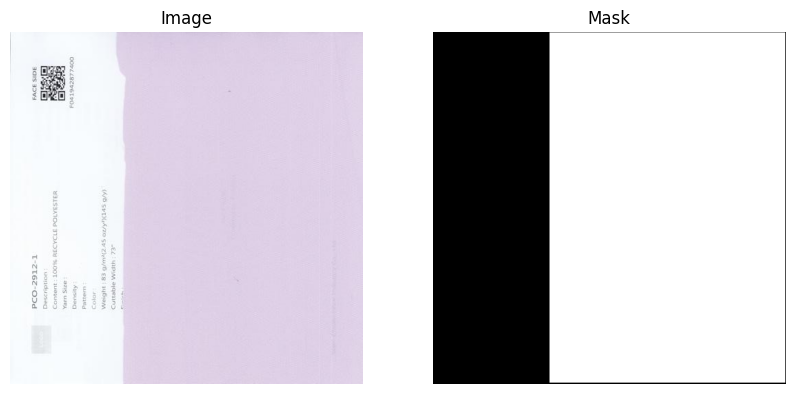

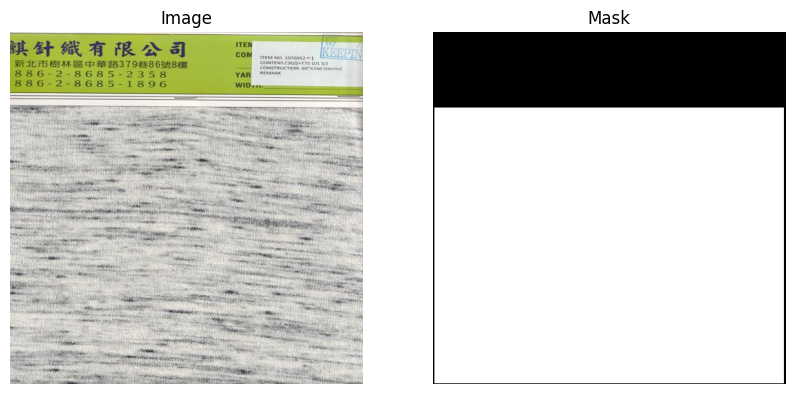

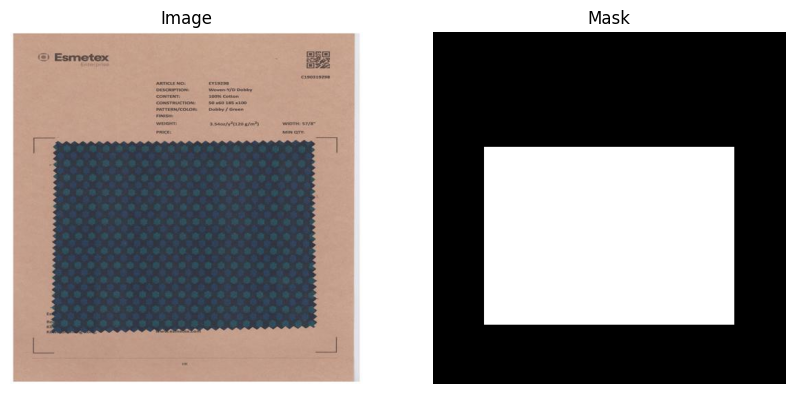

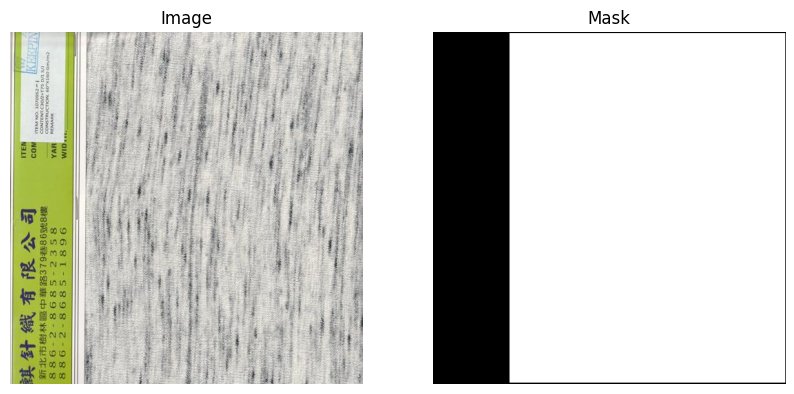

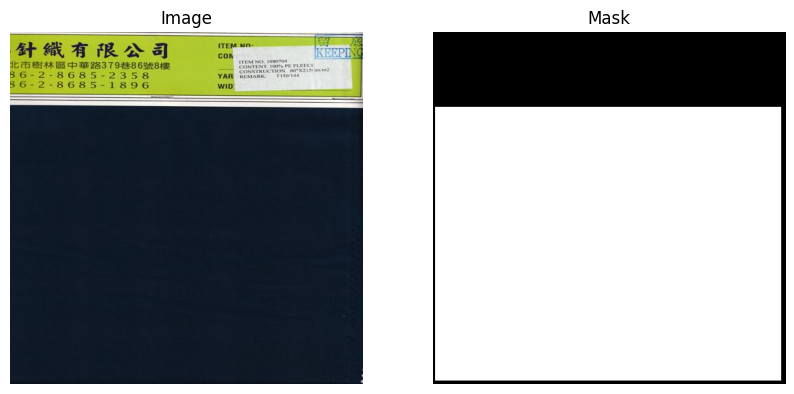

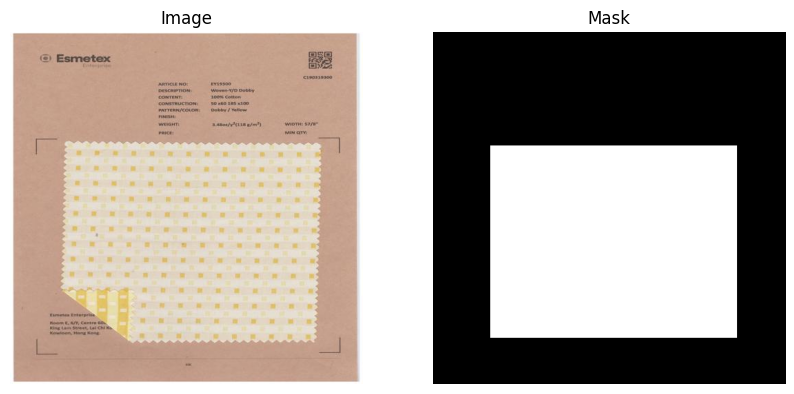

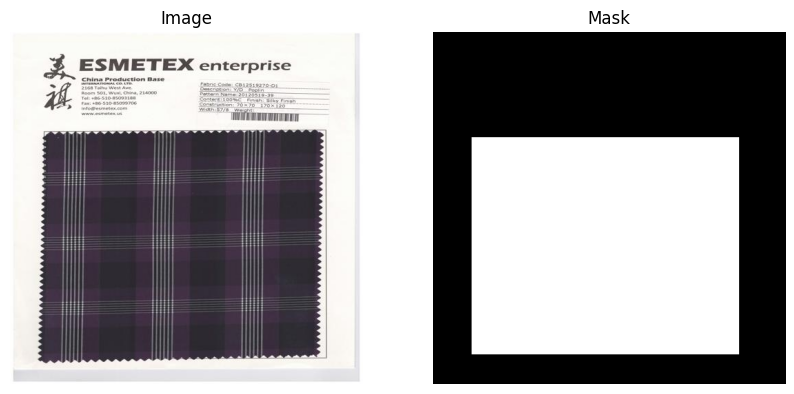

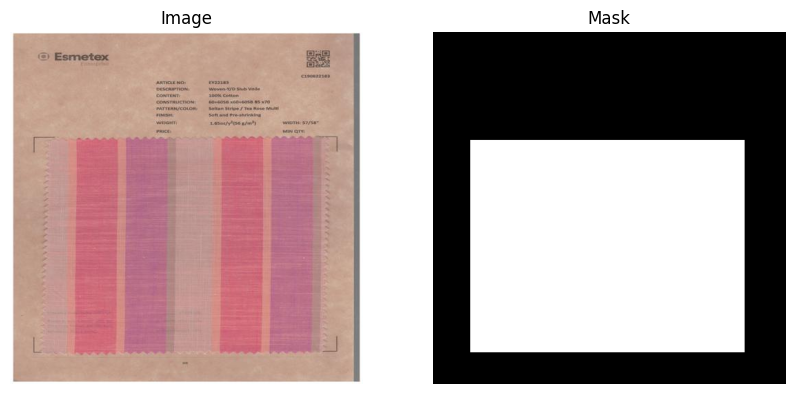

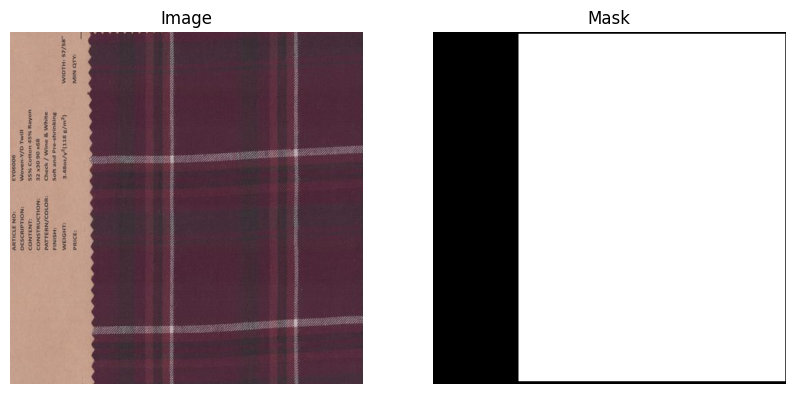

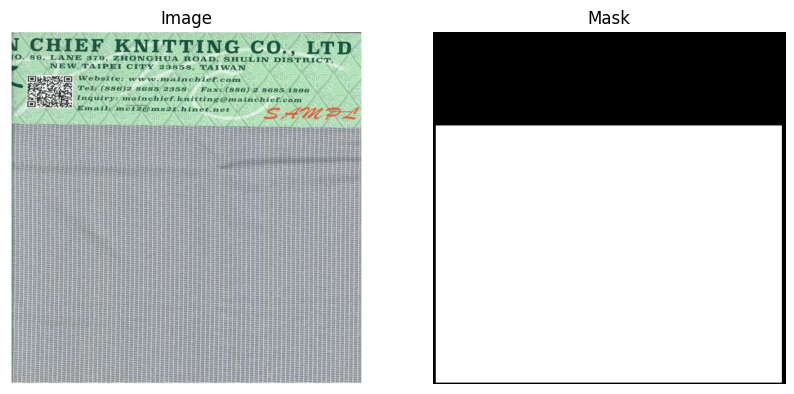

In [3]:
import random
import matplotlib.pyplot as plt

random.seed(42)

# Randomly select 10 indices
sample_indices = random.sample(range(len(train_images)), 10)

# Visualize the selected images and masks
for i in sample_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(train_images[i])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(train_masks[i].squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()


#### **Model Building**

For the model, I decided to use a U-Net architecture, renowned for image segmentation tasks. I conducted several experiments, including tuning training metrics, regularization, batch size, and learning rate parameters using grid search.

Initially, I used accuracy as the training metric, but since this is a segmentation task, I added IoU and the dice coefficient as metrics, which resulted in better performance. Therefore, I decided to stick with these metrics.

I also added l2 regularization per layer of 0.001, as I detected signs of overfitting in the model's accuracy and loss plots, which look like this:

![without_regularization_acc.png](without_regularization_acc.png)
![without_regularization_loss.png](without_regularization_loss.png)

Therefore the optimal parameters based on my grid search are a learning rate of 0.001, l2 regularization of 0.001 per layer, and a batch size of 8.

In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import tensorflow.keras.backend as K

def unet_model(input_size=(512, 512, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c5)
    
    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IoU(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    return K.mean(intersection / union)

# Compile the model
model = unet_model()
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', IoU, dice_coefficient])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

#### **Model Training**

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define model checkpoint and early stopping callbacks
checkpoint = ModelCheckpoint('unet_model.keras', verbose=2, save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_masks, validation_split=0.2, batch_size=8, epochs=50, callbacks=[checkpoint, early_stopping])

Epoch 1/50


2024-05-17 12:06:27.297202: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[8,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,512,512]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-17 12:06:27.369380: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.072291968s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[8,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,512,512]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is

48/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6575 - dice_coefficient: 0.5734 - io_u: 0.4025 - loss: 2.9279

2024-05-17 12:12:40.336291: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,512,512]{3,2,1,0}, f32[2,64,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-17 12:12:40.349024: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.012836143s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,512,512]{3,2,1,0}, f32[2,64,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-17 12:12:42.217184: E external/loca

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6593 - dice_coefficient: 0.5750 - io_u: 0.4043 - loss: 2.9003
Epoch 1: val_loss improved from inf to 0.55513, saving model to unet_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 545s 4s/step - accuracy: 0.6610 - dice_coefficient: 0.5766 - io_u: 0.4060 - loss: 2.8738 - val_accuracy: 0.8186 - val_dice_coefficient: 0.7502 - val_io_u: 0.6028 - val_loss: 0.5551
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8182 - dice_coefficient: 0.7439 - io_u: 0.5864 - loss: 0.5427
Epoch 2: val_loss did not improve from 0.55513
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8183 - dice_coefficient: 0.7439 - io_u: 0.5864 - loss: 0.5425 - val_accuracy: 0.7373 - val_dice_coefficient: 0.7445 - val_io_u: 0.5900 - val_loss: 0.6073
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7770 - dice_coefficient: 0.6878 - io_u: 0.5235 - loss: 0.5685
Epoch 3: val_loss improved from 0.55513 to 0.44489, saving model to unet_model.keras
49/49 ━━

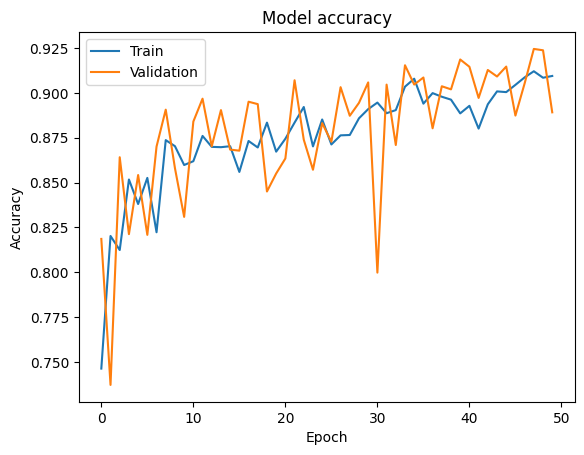

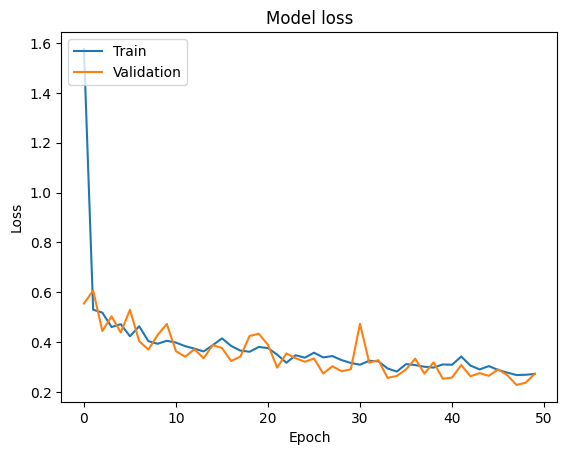

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### **Model Evaluation**

In [10]:
predictions = model.predict(test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  


In [11]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred = (y_pred > 0.5).astype(int)
    
    iou = jaccard_score(y_true, y_pred)
    dice = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return iou, dice, accuracy

ious = []
dices = []
accuracies = []
for i in range(len(test_masks)):
    iou, dice, accuracy = calculate_metrics(test_masks[i], predictions[i])
    ious.append(iou)
    dices.append(dice)
    accuracies.append(accuracy)

print(f"Average IoU: {np.mean(ious)}")
print(f"Average Dice Coefficient: {np.mean(dices)}")
print(f"Average Accuracy: {np.mean(accuracies)}")


Average IoU: 0.8521666306329526
Average Dice Coefficient: 0.8758834423961503
Average Accuracy: 0.916976091338367


Below is the confusion matrix of my model's predictions. On my model training, I didn't add recall, precision, or F1 score as metrics, and only uses accuracy (among these four). This is because the false positives (FP) and false negatives (FN) are fairly balanced, and the nature of the task does not require a specific focus on FP or FN.

Given this balance and the task requirements, I concluded that accuracy remains a suitable metric for evaluation.

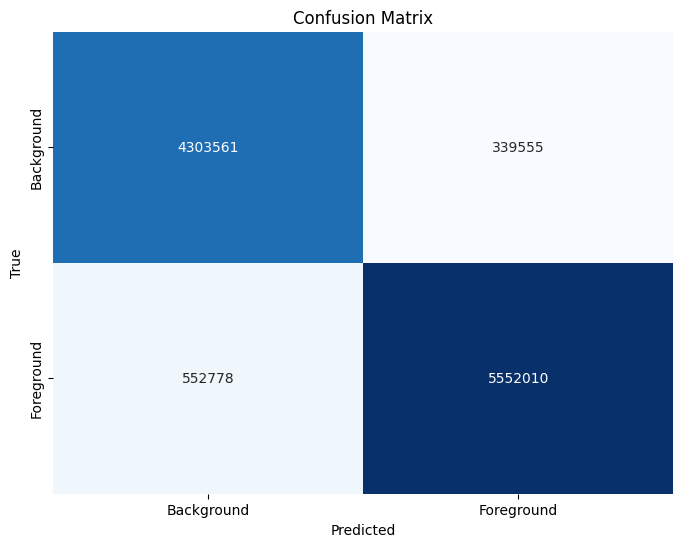

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert masks to binary
threshold = 0.5
binary_ground_truth = (test_masks > threshold).astype(int).flatten()
binary_predictions = (predictions > threshold).astype(int).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(binary_ground_truth, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Background', 'Foreground'],
            yticklabels=['Background', 'Foreground'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### **Other Experiments**

I tried implementing histogram equalization on the images before augmentation, hoping to ease the segmentation by increasing the color contrasts in an image. Some samples of the histogram equalized training images look like this:

![histoequal_1](histoequal_1.png)
![histoequal_2](histoequal_2.png)
![histoequal_3](histoequal_3.png)

However, this approach worsened the model's performance, so I decided not to use it.